In [110]:
%load_ext autoreload
%autoreload 2
%env https_proxy=http://proxy:80
%env http_proxy=http://proxy:80

import wandb
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

api = wandb.Api()
project_path = "team-cr/model-inversion-gen3"  # Replace with your WandB username/project

all_runs = api.runs(project_path)
run_names = [run.name for run in all_runs]
duplicates = set([name for name in run_names if run_names.count(name) > 1])

print(f"Duplicate run names: {duplicates}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: https_proxy=http://proxy:80
env: http_proxy=http://proxy:80


wandb: Currently logged in as: christopher-rossbach (team-cr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Duplicate run names: {'ref_ref_resnet101_loss_rerun_test_rn-mse_1_tv-squared_relu_1_ref-resnet101-1_14042.jpg'}


In [111]:
IMG_NAMES = {
    'fish': 'n01440764_44.JPEG',
    'dog': 'n02086646_567.JPEG',
    'safe': 'n04125021_4187.JPEG',
}
ORIGINAL_IMAGES = {
    'fish': Image.open('/home/woody/iwi1/iwi1106h/data/imagenet/train/n01440764/n01440764_44.JPEG'),
    'dog': Image.open('/home/woody/iwi1/iwi1106h/data/imagenet/train/n02086646/n02086646_567.JPEG'),
    'safe': Image.open('/home/woody/iwi1/iwi1106h/data/imagenet/train/n04125021/n04125021_4187.JPEG'),
}
def crop_to_square(img):
    w, h = img.size
    min_side = min(w, h)
    left = (w - min_side) // 2
    top = (h - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    return img.crop((left, top, right, bottom))

ORIGINAL_IMAGES = {k: crop_to_square(v) for k, v in ORIGINAL_IMAGES.items()}
def get_img(tags, image_name, index=None):
    run = next(r for r in all_runs if all(tag in r.tags for tag in tags) and r.config.get('image_name') == IMG_NAMES[image_name])
    key = f"reconstruction_{IMG_NAMES[image_name]}"
    if index is not None:
        key += f"_{index}"
    history = run.history(keys=[key], pandas=False)
    last_img = history[-1][key]
    img_file = run.file(last_img['path']).download(exist_ok=True)
    img = Image.open(img_file.name)

    return img

imgs = [
    [ORIGINAL_IMAGES['safe'], get_img(['normal'], 'safe', index=3), get_img(['clip'], 'safe', index=0)],
    [ORIGINAL_IMAGES['dog'], get_img(['normal'], 'dog', index=1), get_img(['clip'], 'dog', index=2)],
    [ORIGINAL_IMAGES['fish'], get_img(['normal'], 'fish', index=5), get_img(['clip'], 'fish', index=3)],
]

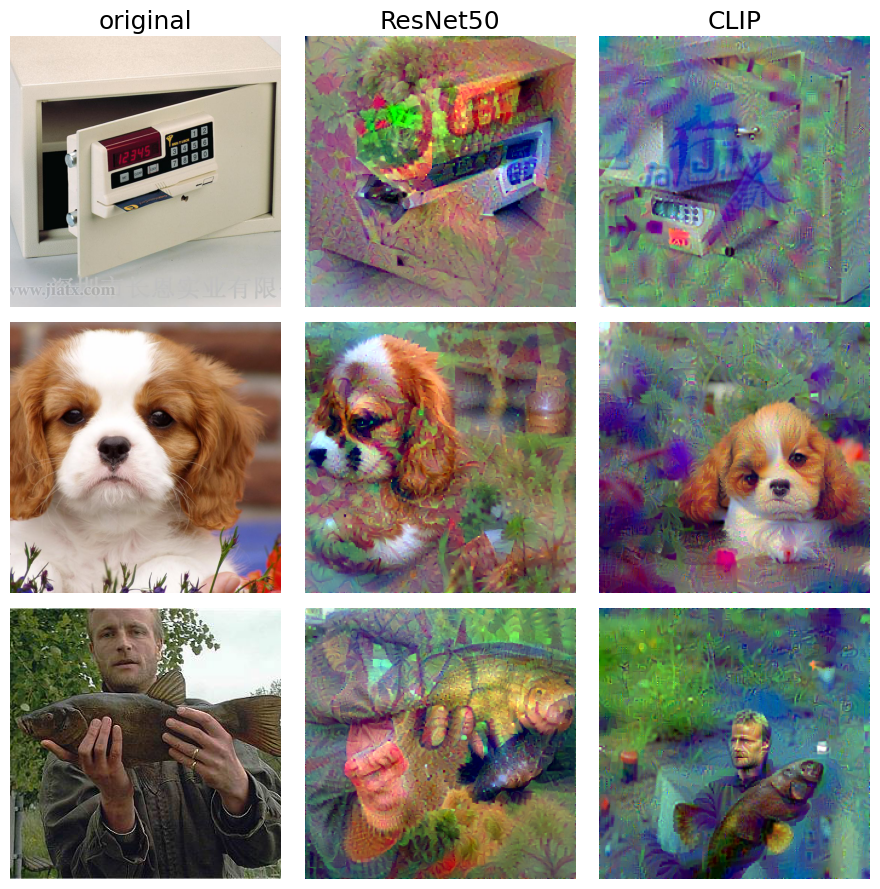

In [112]:
fig, axes = plt.subplots(len(imgs), len(imgs[0]), figsize=(9, 9))
for j, col_name in enumerate(['original', 'ResNet50', 'CLIP']):
    axes[0, j].set_title(col_name, fontsize=18)

for i, row in enumerate(imgs):
    for j, img in enumerate(row):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
plt.tight_layout()
plt.axis('off')
plt.show()
os.makedirs('out/figures', exist_ok=True)
fig.savefig('out/figures/resnet-vs-clip.pdf', bbox_inches='tight')

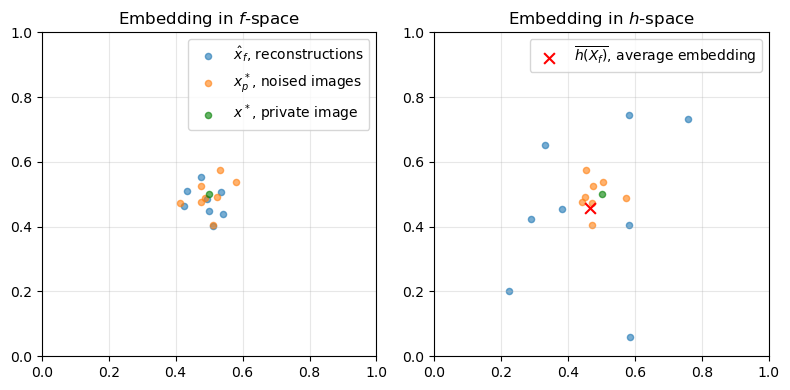

In [113]:
# Center point
center = np.array([0.5, 0.5])

# Parameters
small_radius = 0.05
wide_radius = 0.25
n_points = 8
np.random.seed(42)

# Generate orange points (small radius)
orange_points = center + np.random.normal(scale=small_radius, size=(n_points, 2))
orange_points_2 = center + np.random.normal(scale=small_radius, size=(n_points, 2))

# Generate blue points (small radius)
blue_points = center + np.random.normal(scale=small_radius, size=(n_points, 2))

# Generate wide blue points (wide radius)
wide_blue_points = center + np.random.normal(scale=wide_radius, size=(n_points, 2))
wide_blue_avg = wide_blue_points.mean(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# First plot: green center, orange and blue points (small radius)
axes[0].scatter(blue_points[:, 0], blue_points[:, 1], s=20, alpha=0.6, label=r'$\hat x_f$, reconstructions')
axes[0].scatter(orange_points[:, 0], orange_points[:, 1], s=20, alpha=0.6, label=r'$x^*_p$, noised images')
axes[0].scatter(center[0], center[1], color='green', s=20, alpha=0.6, label=r'$x^*$, private image')
axes[0].set_title(r'Embedding in $f$-space')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Second plot: green center, orange (small), blue (wide), red cross at avg
axes[1].scatter(wide_blue_points[:, 0], wide_blue_points[:, 1], s=20, alpha=0.6)
axes[1].scatter(orange_points_2[:, 0], orange_points[:, 1], s=20, alpha=0.6)
axes[1].scatter(center[0], center[1], color='green', s=20, alpha=0.6)
axes[1].scatter(wide_blue_avg[0], wide_blue_avg[1], color='red', marker='x', s=60, label=r'$\overline{h(X_f)}$, average embedding', zorder=5)
axes[1].set_title(r'Embedding in $h$-space')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig.savefig('out/figures/avg-embedding-sketch.pdf', bbox_inches='tight')

In [5]:
def get_runs_filered(one_of, all_of=None, none_of=None):
    if all_of is None:
        all_of = []
    if none_of is None:
        none_of = []
    filtered = [
        run for run in all_runs
        if any(tag in run.tags for tag in one_of)
        and all(tag in run.tags for tag in all_of)
        and all(tag not in run.tags for tag in none_of)
        and 'test' not in run.tags
        and 'no_avg_pool' not in run.tags
        and 'second_init' not in run.tags
    ]
    for run in filtered:
        if not run.config.get('loss_scale',{}).get('rn', None):
            print(f"Run {run.name} missing loss_scale.rn")
    filtered = [run for run in filtered if
                run.config.get('loss_scale', {}).get('rn', None)
                and float(run.config.get('loss_scale', {}).get('rn', None)) == 1.0
                ]
    return filtered

def get_run_data(runs):
    metrics = ['losses_unscaled.ssim_loss.11', 'losses_unscaled.lpips_loss_alex', 'losses_unscaled.lpips_loss_vgg', 'losses_unscaled.clip_loss_unscaled']
    records = []

    for run in tqdm(runs, desc="Processing runs"):
        history = run.history(keys=metrics, pandas=True)
        last_100 = history.tail(100)
        avg_values = last_100.mean()
        record = {
            'run_id': run.id,
            'run_name': run.name,
            'tags': run.tags,
            'image_name': run.config.get('image_name', 'N/A'),
            'ssim_11_avg': 1 - avg_values['losses_unscaled.ssim_loss.11'],
            'lpips_alex_avg': avg_values['losses_unscaled.lpips_loss_alex'],
            'lpips_vgg_avg': avg_values['losses_unscaled.lpips_loss_vgg'],
            'clip_loss_avg': 1 - avg_values['losses_unscaled.clip_loss_unscaled'],
        }
        records.append(record)

    metrics_df = pd.DataFrame(records)
    return metrics_df


In [6]:
from collections import defaultdict

tags_to_filter = ['ref', 'ref_nrl', 'avg', 'avg_nrl']
data_sets = ['in1', 'in2', 'ffhq']
number_of_recons = {'only_4': 4, 'only_8': 8, 'only_16': 16}

runs = defaultdict(lambda: defaultdict(dict))
for data_set in data_sets:
    for num_imgs_tag, num_recons in number_of_recons.items():
        filtered_runs = get_runs_filered(one_of=tags_to_filter, all_of=[data_set, num_imgs_tag], none_of=[])
        runs[data_set][num_imgs_tag] = filtered_runs
        if len(filtered_runs) != 8 * (8 + 8 + (1 + 8 + 1 + 8)):
            print("!! Warning: loaded a different number of runs then expected!")
            print(f"Expecting {8 * (8 + 8 + (1 + 8 + 1 + 8))} runs.")
            print(f"Number of filtered runs for {data_set}, {num_imgs_tag}: {len(filtered_runs)}")


In [7]:
import pickle
import os

raw_data_file = 'embeddings/raw_run_data.pkl'

if os.path.exists(raw_data_file):
    with open(raw_data_file, 'rb') as f:
        raw_run_data = pickle.load(f)
    print("Loaded raw_run_data from file.")
else:
    raw_run_data = defaultdict(lambda: defaultdict(dict))
    for data_set in data_sets:
        for num_imgs_tag in number_of_recons.keys():
            print(f"Loading data for {data_set}, {num_imgs_tag}...")
            raw_run_data[data_set][num_imgs_tag] = get_run_data(runs[data_set][num_imgs_tag])
    with open(raw_data_file, 'wb') as f:
        pickle.dump(dict(raw_run_data), f)

Loaded raw_run_data from file.


In [95]:
def preprocess_data(metrics_df, recon_cnt):
    metrics_df_agg = metrics_df.explode('tags').groupby('tags').agg(
        ssim_11_avg=('ssim_11_avg', 'mean'),
        lpips_alex_avg=('lpips_alex_avg', 'mean'),
        lpips_vgg_avg=('lpips_vgg_avg', 'mean'),
        clip_loss_avg=('clip_loss_avg', 'mean')
    ).reset_index()

    metrics_df_agg = metrics_df_agg[metrics_df_agg['tags'].str.contains('init|avg_[^n]|ref_[^n]|avg_nrl_|ref_nrl_', regex=True)].reset_index(drop=True)

    split_tags = metrics_df_agg['tags'].str.split('_')
    metrics_df_agg['backbone'] = split_tags.str[-1]
    metrics_df_agg['backbone'] = metrics_df_agg['backbone'].str.replace('resnet', 'rn')
    metrics_df_agg['backbone'] = metrics_df_agg['backbone'].str.replace('init', '--')
    metrics_df_agg['type'] = split_tags.str[0]
    metrics_df_agg['type'] = metrics_df_agg['type'].str.replace('init', 'baseline')
    metrics_df_agg['relu'] = split_tags.apply(lambda x: "no" if len(x) == 3 else "yes")

    backbone_order = ['--', 'rn18', 'rn34', 'rn50', 'rn101', 'rn152', 'vgg16', 'vgg19', 'clip']
    type_order = ['baseline', 'avg', 'ref']
    relu_order = ['yes', 'no']

    def get_sort_key(order_list, x):
        try:
            return order_list.index(x)
        except ValueError:
            return len(order_list) + 1

    backbone_sort_key = lambda x: get_sort_key(backbone_order, x)
    type_sort_key = lambda x: get_sort_key(type_order, x)
    relu_sort_key = lambda x: get_sort_key(relu_order, x)

    base_table = metrics_df_agg.copy()
    base_table['backbone_sort'] = base_table['backbone'].apply(backbone_sort_key)
    base_table['type_sort'] = base_table['type'].apply(type_sort_key)
    base_table['relu_sort'] = base_table['relu'].apply(relu_sort_key)
    base_table = base_table.sort_values(['backbone_sort','type_sort', 'relu_sort'])
    base_table['count'] = recon_cnt
    base_table = base_table[['type', 'relu', 'backbone', 'ssim_11_avg', 'lpips_vgg_avg', 'lpips_alex_avg', 'clip_loss_avg', 'count']]

    base_table = base_table[~((base_table['relu'] == 'yes') & (base_table['backbone'] == 'clip'))]

    return base_table

In [96]:
run_data = defaultdict(lambda: defaultdict(dict))
for data_set in data_sets:
    for (num_imgs_tag, num_recons) in number_of_recons.items():
        run_data[data_set][num_imgs_tag] = preprocess_data(raw_run_data[data_set][num_imgs_tag], num_recons)

In [97]:
def diff_str(metric, val):
    diff = val
    sign = '+' if diff >= 0 else ''
    color = 'black'
    if abs(diff) < 0.5e-3:
        color = 'black'
    elif ('lpips' in metric and diff < 0) or (('lpips' not in metric) and diff > 0):
        color = 'green'
    else:
        color = 'red'
    return f"{{\\color{{{color}}}({sign}{diff:.3f})}}"

def make_latex_table_from_df(df: pd.DataFrame, hline_at, reference_at, path: str, header: list) -> str:
    lines = []
    for idx, row in df.iterrows():
        str_cols = [col for col in df.columns if df[col].dtype == object and not col.endswith('_diff')]
        num_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number) and not col.endswith('_diff')]
        line_parts = []
        for col in str_cols:
            line_parts.append(str(row[col]))
        for col in num_cols:
            if isinstance(row[col], int):
                val = f"{row[col]}"
            else:
                val = f"{row[col]:.3f}"
            diff_col = f"{col}_diff"
            if diff_col in df.columns and not pd.isnull(row[diff_col]):
                val += " " + diff_str(col, row[diff_col])
            line_parts.append(f"\\texttt{{{val}}}")
        lines.append(" & ".join(line_parts) + r" \\")
    col_align = ['l' if df[col].dtype == object and not col.endswith('_diff') else 'c' for col in df.columns if not col.endswith('_diff')]

    with open(path, 'w') as f:
        f.write(r"\begin{tabular}{" + "|" + "|".join(col_align) + "|}\n")
        f.write(r"\hline" + '\n')
        f.write(" & ".join(header) + r" \\" + '\n')
        f.write(r"\hline" + '\n')
        for i, line in enumerate(lines):
            f.write(("\\rowcolor{verylightgray}" if reference_at(df, i) else "") + line + '\n')
            if i < len(lines) - 1 and hline_at(df,i):
                f.write(r"\hline" + '\n')
        f.write(r"\hline" + '\n')
        f.write(r"\end{tabular}" + '\n')

In [98]:
def make_overview_table(base_table):
    table_01_metrics = base_table.copy()

    baseline_row = table_01_metrics[table_01_metrics['type'] == 'baseline'].iloc[0]
    baseline_metrics = {
        'ssim_11_avg': baseline_row['ssim_11_avg'],
        'lpips_vgg_avg': baseline_row['lpips_vgg_avg'],
        'lpips_alex_avg': baseline_row['lpips_alex_avg'],
        'clip_loss_avg': baseline_row['clip_loss_avg'],
    }

    table_01_metrics['ssim_11_avg_diff'] = table_01_metrics['ssim_11_avg'] - baseline_metrics['ssim_11_avg']
    table_01_metrics['lpips_vgg_avg_diff'] = table_01_metrics['lpips_vgg_avg'] - baseline_metrics['lpips_vgg_avg']
    table_01_metrics['lpips_alex_avg_diff'] = table_01_metrics['lpips_alex_avg'] - baseline_metrics['lpips_alex_avg']
    table_01_metrics['clip_loss_avg_diff'] = table_01_metrics['clip_loss_avg'] - baseline_metrics['clip_loss_avg']


    def line_hline_at(df, i):
        return df.iloc[i]['type'] == 'baseline' or (len(df) > i + 1 and df.iloc[i+1]['backbone'] != df.iloc[i]['backbone'])

    make_latex_table_from_df(
        table_01_metrics,
        hline_at=line_hline_at,
        reference_at=lambda df, i: df.iloc[i]['type'] == 'baseline',
        path='out/figures/experiments_table.tex',
        header=['Type', 'ReLU', '$h$', r'SSIM $\uparrow$', r'LPIPS VGG $\downarrow$', r'LPIPS Alex $\downarrow$', r'CLIP cos sim $\uparrow$', r'$m$']
    )

In [99]:
def make_relu_table(base_table):
    table_02_metrics = base_table.copy()[~base_table['type'].str.contains('baseline') & (base_table['backbone'] != 'clip')]
    for col in ['ssim_11_avg', 'lpips_alex_avg', 'lpips_vgg_avg', 'clip_loss_avg']:
        diff_col = f"{col}_diff"
        table_02_metrics[diff_col] = np.nan
        for idx, row in table_02_metrics.iterrows():
            mask = (
                (table_02_metrics['backbone'] == row['backbone']) &
                (table_02_metrics['type'] == row['type']) &
                (table_02_metrics['relu'] == 'yes')
            )
            relu_row = table_02_metrics[mask]
            if not relu_row.empty:
                table_02_metrics.at[idx, diff_col] = row[col] - relu_row.iloc[0][col]
                

    def line_hline_at(df, i):
        return df.iloc[i]['type'] == 'baseline' or (df.iloc[i]['relu'] == 'no')

    make_latex_table_from_df(
        table_02_metrics,
        hline_at=line_hline_at,
        reference_at=lambda df, i: df.iloc[i]['relu'] == 'yes',
        path='out/figures/experiments_table_relu.tex',
        header=['Type', 'ReLU', '$h$', r'SSIM $\uparrow$', r'LPIPS VGG $\downarrow$', r'LPIPS Alex $\downarrow$', r'CLIP cos sim $\uparrow$', r'$m$']
    )

In [100]:
def make_avg_table(base_table):
    table_03_metrics = base_table.copy()[~base_table['type'].str.contains('baseline')]
    for col in ['ssim_11_avg', 'lpips_alex_avg', 'lpips_vgg_avg', 'clip_loss_avg']:
        diff_col = f"{col}_diff"
        table_03_metrics[diff_col] = np.nan
        for idx, row in table_03_metrics.iterrows():
            mask = (
                (table_03_metrics['backbone'] == row['backbone']) &
                (table_03_metrics['type'] == 'avg') &
                (table_03_metrics['relu'] == row['relu'])
            )
            relu_row = table_03_metrics[mask]
            if not relu_row.empty:
                table_03_metrics.at[idx, diff_col] = row[col] - relu_row.iloc[0][col]
                

    def line_hline_at(df, i):
        return df.iloc[i]['type'] == 'baseline' or (df.iloc[i]['relu'] == 'no')

    make_latex_table_from_df(
        table_03_metrics,
        hline_at=line_hline_at,
        reference_at=lambda df, i: df.iloc[i]['type'] == 'avg',
        path='out/figures/experiments_table_avg.tex',
        header=['Type', 'ReLU', '$h$', r'SSIM $\uparrow$', r'LPIPS VGG $\downarrow$', r'LPIPS Alex $\downarrow$', r'CLIP cos sim $\uparrow$', r'$m$']
    )

In [101]:
def make_backbone_tables(base_table):
    table_04_metrics = base_table.copy()[~base_table['type'].str.contains('baseline')]
    for col in ['ssim_11_avg', 'lpips_alex_avg', 'lpips_vgg_avg', 'clip_loss_avg']:
        diff_col = f"{col}_diff"
        table_04_metrics[diff_col] = np.nan
        for idx, row in table_04_metrics.iterrows():
            if 'vgg' in row['backbone']:
                mask = (
                    (table_04_metrics['backbone'] == 'vgg16') &
                    (table_04_metrics['type'] == row['type']) &
                    (table_04_metrics['relu'] == row['relu'])
                )
            else:
                mask = (
                    (table_04_metrics['backbone'] == 'rn50') &
                    (table_04_metrics['type'] == row['type']) &
                    (table_04_metrics['relu'] == row['relu'])
                )
            relu_row = table_04_metrics[mask]
            if not relu_row.empty:
                table_04_metrics.at[idx, diff_col] = row[col] - relu_row.iloc[0][col]
                

    def line_hline_at(df, i):
        return (df.iloc[i]['relu'] == 'no' and df.iloc[i]['type'] == 'ref')

    make_latex_table_from_df(
        table_04_metrics[table_04_metrics['backbone'].str.contains('rn')],
        hline_at=line_hline_at,
        reference_at=lambda df, i: df.iloc[i]['backbone'] == 'rn50',
        path='out/figures/experiments_table_rn50.tex',
        header=['Type', 'ReLU', '$h$', r'SSIM $\uparrow$', r'LPIPS VGG $\downarrow$', r'LPIPS Alex $\downarrow$', r'CLIP cos sim $\uparrow$', r'$m$']
    )

    make_latex_table_from_df(
        table_04_metrics[table_04_metrics['backbone'].str.contains('vgg')],
        hline_at=line_hline_at,
        reference_at=lambda df, i: df.iloc[i]['backbone'] == 'vgg16',
        path='out/figures/experiments_table_vgg16.tex',
        header=['Type', 'ReLU', '$h$', r'SSIM $\uparrow$', r'LPIPS VGG $\downarrow$', r'LPIPS Alex $\downarrow$', r'CLIP cos sim $\uparrow$', r'$m$']
    )

In [102]:
def make_diff_table(base_table, new_table, path):
    display_table = new_table.copy()
    for col in ['ssim_11_avg', 'lpips_alex_avg', 'lpips_vgg_avg', 'clip_loss_avg']:
        diff_col = f"{col}_diff"
        display_table[diff_col] = display_table[col] - base_table[col]

    def line_hline_at(df, i):
        return i < df.shape[0] - 1 and (df.iloc[i+1]['backbone'] != df.iloc[i]['backbone'])

    make_latex_table_from_df(
        display_table,
        hline_at=line_hline_at,
        reference_at=lambda df, i: False,
        path=path,
        header=['Type', 'ReLU', '$h$', r'SSIM $\uparrow$', r'LPIPS VGG $\downarrow$', r'LPIPS Alex $\downarrow$', r'CLIP cos sim $\uparrow$', r'$m$']
    )
def best_rows_only(df, allowed_backbones=None, additional_backbones=[]):
    if allowed_backbones is None:
        allowed_backbones = ['rn152', 'clip', 'vgg19']
    allowed_backbones += additional_backbones
    return df[((df['type'] == 'baseline') & ('--' in allowed_backbones))|
        (
            (df['type'] == 'ref') &
            (df['relu'] == 'yes') &
            (df['backbone'].isin(set(allowed_backbones) - set(['clip'])))
        )|
        (
            (df['type'] == 'ref') &
            (df['backbone'] == 'clip') &
            ('clip' in allowed_backbones) &
            (df['relu'] == 'no')
        )
    ].copy()

In [103]:
def make_best_row_table(base_table):
    table = best_rows_only(base_table, additional_backbones=['--'])


    baseline_row = table[table['type'] == 'baseline'].iloc[0]
    baseline_metrics = {
        'ssim_11_avg': baseline_row['ssim_11_avg'],
        'lpips_vgg_avg': baseline_row['lpips_vgg_avg'],
        'lpips_alex_avg': baseline_row['lpips_alex_avg'],
        'clip_loss_avg': baseline_row['clip_loss_avg'],
    }

    table['ssim_11_avg_diff'] = table['ssim_11_avg'] - baseline_metrics['ssim_11_avg']
    table['lpips_vgg_avg_diff'] = table['lpips_vgg_avg'] - baseline_metrics['lpips_vgg_avg']
    table['lpips_alex_avg_diff'] = table['lpips_alex_avg'] - baseline_metrics['lpips_alex_avg']
    table['clip_loss_avg_diff'] = table['clip_loss_avg'] - baseline_metrics['clip_loss_avg']


    def line_hline_at(df, i):
        return df.iloc[i]['type'] == 'baseline' or (len(df) > i + 1 and df.iloc[i+1]['backbone'] != df.iloc[i]['backbone'])

    make_latex_table_from_df(
        table,
        hline_at=line_hline_at,
        reference_at=lambda df, i: df.iloc[i]['type'] == 'baseline',
        path='out/figures/experiments_best_rows_table.tex',
        header=['Type', 'ReLU', '$h$', r'SSIM $\uparrow$', r'LPIPS VGG $\downarrow$', r'LPIPS Alex $\downarrow$', r'CLIP cos sim $\uparrow$', r'$m$']
    )

In [104]:
def make_recon_count_tables(small, normal, big):
    small = best_rows_only(small)
    normal = best_rows_only(normal)
    big = best_rows_only(big)

    make_diff_table(small, normal, 'out/figures/experiments_table_04_to_08_recons.tex')
    make_diff_table(small, big, 'out/figures/experiments_table_04_to_16_recons.tex')
    make_diff_table(normal, big, 'out/figures/experiments_table_08_to_16_recons.tex')

In [105]:
def make_all_tables(base_table):
    make_best_row_table(base_table)
    make_relu_table(base_table)
    make_avg_table(base_table)
    make_backbone_tables(base_table)

ds_to_use = 'in1'
make_all_tables(run_data[ds_to_use]['only_4'])

#make_recon_count_tables(only_42, only_82, imagenet_val2)
make_recon_count_tables(run_data[ds_to_use]['only_4'], run_data[ds_to_use]['only_8'], run_data[ds_to_use]['only_16'])

In [106]:
rd_in1 = run_data['in1']['only_4'].copy()
rd_ffhq = run_data['ffhq']['only_4'].copy()

def subtract_baseline(df):
    baseline_row = df[df['type'] == 'baseline'].iloc[0]
    baseline_metrics = {
        'ssim_11_avg': baseline_row['ssim_11_avg'],
        'lpips_vgg_avg': baseline_row['lpips_vgg_avg'],
        'lpips_alex_avg': baseline_row['lpips_alex_avg'],
        'clip_loss_avg': baseline_row['clip_loss_avg'],
    }

    df['ssim_11_avg'] = df['ssim_11_avg'] - baseline_metrics['ssim_11_avg']
    df['lpips_vgg_avg'] = df['lpips_vgg_avg'] - baseline_metrics['lpips_vgg_avg']
    df['lpips_alex_avg'] = df['lpips_alex_avg'] - baseline_metrics['lpips_alex_avg']
    df['clip_loss_avg'] = df['clip_loss_avg'] - baseline_metrics['clip_loss_avg']
    return df

rd_in1 = best_rows_only(subtract_baseline(rd_in1))
rd_ffhq = best_rows_only(subtract_baseline(rd_ffhq))

make_diff_table(rd_in1, rd_ffhq, 'out/figures/experiments_in_vs_ffhq.tex')
run_data['in1']['only_4']

type relu backbone  ssim_11_avg  lpips_vgg_avg  lpips_alex_avg  \
16  baseline  yes       --     0.176768       0.750823        0.778251   
11       avg  yes     rn18     0.176417       0.792817        0.795635   
4        avg   no     rn18     0.175738       0.816785        0.807250   
28       ref  yes     rn18     0.170183       0.778195        0.786405   
21       ref   no     rn18     0.167961       0.795013        0.792931   
12       avg  yes     rn34     0.175172       0.791937        0.794478   
5        avg   no     rn34     0.172677       0.800292        0.794930   
29       ref  yes     rn34     0.166152       0.776387        0.791103   
22       ref   no     rn34     0.166094       0.783126        0.793472   
13       avg  yes     rn50     0.177949       0.761072        0.786621   
6        avg   no     rn50     0.178039       0.767004        0.788878   
30       ref  yes     rn50     0.174928       0.755274        0.778550   
23       ref   no     rn50     0.175491       0.757441        0.781574   
9        avg  yes    rn101     0.178119       0.760612        0.777911   
2        avg   no    rn101     0.177776       0.767121        0.779777   
26       ref  yes    rn101     0.177489       0.757333        0.776106   
19       ref   no    rn101     0.173590       0.759077        0.781125   
10       avg  yes    rn152     0.177842       0.759997        0.777421   
3        avg   no    rn152     0.176462       0.766410        0.780962   
27       ref  yes    rn152     0.173464       0.754793        0.774593   
20       ref   no    rn152     0.176830       0.756269        0.775757   
14       avg  yes    vgg16     0.176463       0.778568        0.787468   
7        avg   no    vgg16     0.184242       0.864127        0.847086   
31       ref  yes    vgg16     0.181724       0.774529        0.788475   
24       ref   no    vgg16     0.173373       0.803039        0.812675   
15       avg  yes    vgg19     0.177541       0.767411        0.784871   
8        avg   no    vgg19     0.174564       0.840575        0.853944   
32       ref  yes    vgg19     0.180725       0.774518        0.784734   
25       ref   no    vgg19     0.174551       0.811977        0.810423   
1        avg   no     clip     0.169862       0.764063        0.795824   
18       ref   no     clip     0.162671       0.768269        0.787841   

    clip_loss_avg  count  
16       0.640731      4  
11       0.599932      4  
4        0.595460      4  
28       0.621179      4  
21       0.602806      4  
12       0.584834      4  
5        0.576138      4  
29       0.623301      4  
22       0.606112      4  
13       0.635879      4  
6        0.628468      4  
30       0.635610      4  
23       0.639728      4  
9        0.631073      4  
2        0.618104      4  
26       0.648219      4  
19       0.635579      4  
10       0.627244      4  
3        0.618995      4  
27       0.645470      4  
20       0.643491      4  
14       0.615618      4  
7        0.564759      4  
31       0.620566      4  
24       0.569859      4  
15       0.615636      4  
8        0.563461      4  
32       0.634437      4  
25       0.592601      4  
1        0.581127      4  
18       0.648230      4

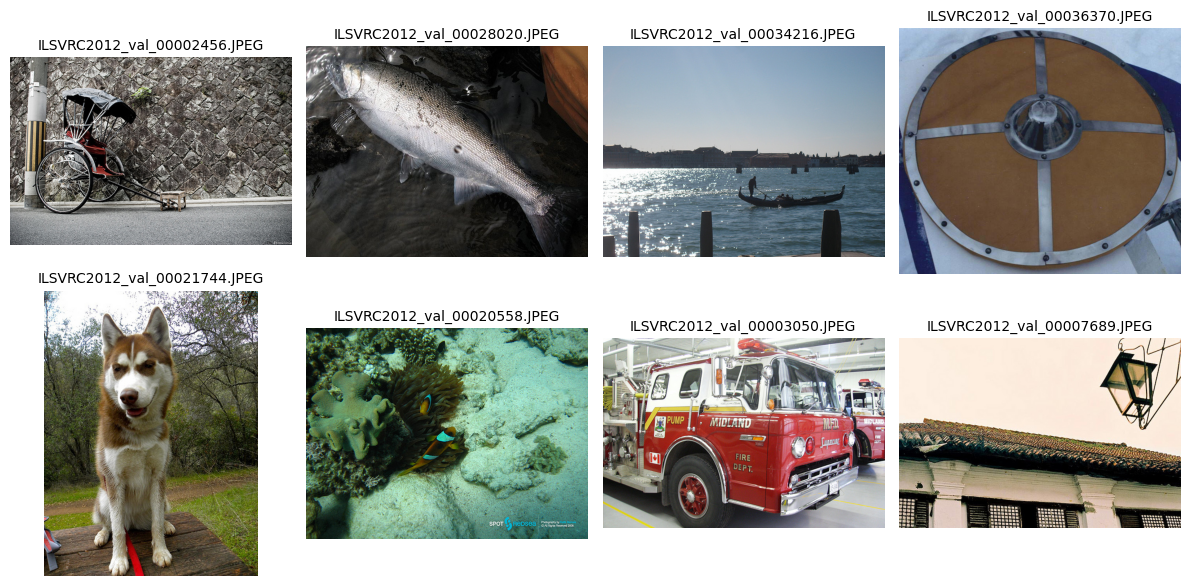

/home/woody/iwi1/iwi1106h/data/imagenet/val/n03599486/ILSVRC2012_val_00002456.JPEG /home/woody/iwi1/iwi1106h/data/imagenet/val/n02536864/ILSVRC2012_val_00028020.JPEG /home/woody/iwi1/iwi1106h/data/imagenet/val/n03447447/ILSVRC2012_val_00034216.JPEG /home/woody/iwi1/iwi1106h/data/imagenet/val/n04192698/ILSVRC2012_val_00036370.JPEG /home/woody/iwi1/iwi1106h/data/imagenet/val/n02109961/ILSVRC2012_val_00021744.JPEG /home/woody/iwi1/iwi1106h/data/imagenet/val/n02607072/ILSVRC2012_val_00020558.JPEG /home/woody/iwi1/iwi1106h/data/imagenet/val/n03345487/ILSVRC2012_val_00003050.JPEG /home/woody/iwi1/iwi1106h/data/imagenet/val/n04435653/ILSVRC2012_val_00007689.JPEG


In [107]:
import random
random.seed(123)
base_dir = '/home/woody/iwi1/iwi1106h/data/imagenet/val'
dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

selected_dirs = random.sample(dirs, 8)
file_paths = []
for d in selected_dirs:
    files = [f for f in os.listdir(os.path.join(base_dir, d)) if os.path.isfile(os.path.join(base_dir, d, f))]
    if files:
        chosen_file = random.choice(files)
        file_paths.append(os.path.join(base_dir, d, chosen_file))

n_cols = 4
n_rows = (len(file_paths) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
for idx, path in enumerate(file_paths):
    img = Image.open(path)
    ax = axes[idx // n_cols, idx % n_cols]
    ax.imshow(img)
    ax.set_title(os.path.basename(path), fontsize=10)
    ax.axis('off')
for idx in range(len(file_paths), n_rows * n_cols):
    axes[idx // n_cols, idx % n_cols].axis('off')
plt.tight_layout()
plt.show()

print(' '.join(file_paths))

/home/woody/iwi1/iwi1106h/data/ffhq/06863.png /home/woody/iwi1/iwi1106h/data/ffhq/35084.png /home/woody/iwi1/iwi1106h/data/ffhq/11427.png /home/woody/iwi1/iwi1106h/data/ffhq/53377.png /home/woody/iwi1/iwi1106h/data/ffhq/34937.png /home/woody/iwi1/iwi1106h/data/ffhq/14116.png /home/woody/iwi1/iwi1106h/data/ffhq/05000.png /home/woody/iwi1/iwi1106h/data/ffhq/49692.png


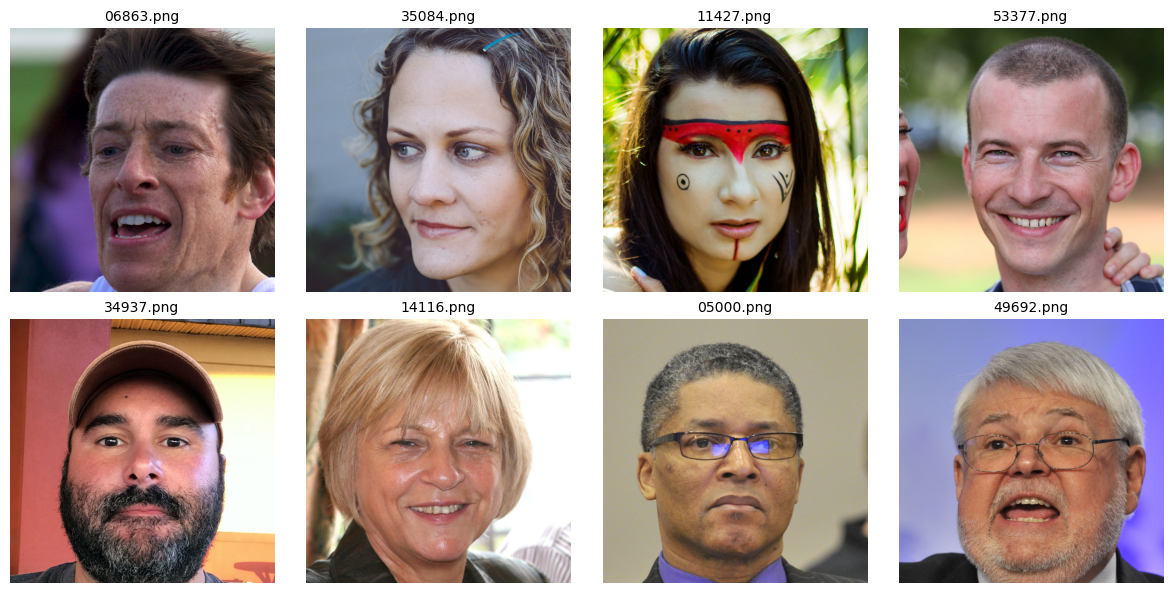

In [108]:
import matplotlib.pyplot as plt
import random
from PIL import Image

random.seed(123)

random_indices = random.sample(range(70000), 8)

base_dir = '/home/woody/iwi1/iwi1106h/data/ffhq'
img_paths = [f"{base_dir}/{index:05d}.png" for index in random_indices]
print(" ".join(img_paths))
n_cols = 4
n_rows = (len(img_paths) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
for idx, path in enumerate(img_paths):
    img = Image.open(path)
    ax = axes[idx // n_cols, idx % n_cols]
    ax.imshow(img)
    ax.set_title(os.path.basename(path), fontsize=10)
    ax.axis('off')
for idx in range(len(img_paths), n_rows * n_cols):
    axes[idx // n_cols, idx % n_cols].axis('off')
plt.tight_layout()
plt.show()